# Results Analysis


In [1]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
path = "C:/Users/Katon/Documents/JHU/SocialMediaAnalytics/final_project/data/"
data = pd.read_csv(path+"final_dataset.csv")
data = data[data['Handle'] != 'NO_HANDLE']
data = data[data['Handle'] != 'SUSPENDED']
data = data[data['num_tweets'] > 1]
data['Vote_Follower_Ratio'] = data.Votes / data.Followers
data['size'] = 1
data.head()

,State,Branch,Type,Election_Date,Party,Candidate,Win,Votes,Incumbent,Handle,Bio,Following,Followers,Bio_Length,bio_polarity,bio_subjectivity,bio_profanity,num_tweets,mean_tweet_length,mean_unique_words,mean_pct_unique,mean_tweet_polarity,std_tweet_polarity,mean_tweet_subjectivity,std_tweet_subjectivity,mean_tweet_profanity,std_tweet_profanity,polarity_coef,subjectivity_coef,profanity_coef,unique_coef,length_coef,pct_unique_coef,Vote_Follower_Ratio,size
0,Alabama,Senate,General,11/8/2022,R,Katie Britt,W,940054,1,KatieBrittforAL,Unapologetically committed putting AlabamaFirs...,2,19798,20,0.800000,0.750000,0.019468,965,31.377202,28.131606,0.896562,0.228550,0.298075,0.443566,0.274657,0.038216,0.049209,1.830000e-05,-0.000006,-0.000002,-0.000503,-0.001155,0.000015,47.482271,1
1,Alabama,Senate,General,11/8/2022,D,Will Boyd,L,435431,0,willboydforAL,Senate Nominee Husband Father Bishop Pastor En...,2224,4176,9,0.000000,0.000000,0.016661,330,30.869697,26.990909,0.874350,0.189708,0.253048,0.352834,0.298292,0.030553,0.034297,1.089450e-04,0.000255,-0.000030,0.010422,0.009264,0.000046,104.269875,1
2,Alabama,Senate,Primary,5/24/2022,D,Brandaun Dean,L,32863,0,BrandaunDean,Black America reparations I justice system pol...,207,2618,16,-0.166667,0.433333,0.076919,1602,22.825843,20.606987,0.902792,0.012198,0.242736,0.345183,0.288341,0.178219,0.268846,-4.250000e-07,-0.000033,0.000008,-0.003128,-0.003749,0.000017,12.552712,1
5,Alabama,Senate,Primary,5/24/2022,R,Katie Britt,W,268949,1,KatieBrittforAL,Unapologetically committed putting AlabamaFirs...,2,19798,20,0.800000,0.750000,0.019468,1034,29.222437,26.362669,0.902138,0.260732,0.290374,0.448073,0.277613,0.035742,0.045185,3.580000e-05,-0.000028,-0.000010,-0.006170,-0.006987,0.000026,13.584655,1
9,Alabama,Senate,Primary,5/24/2022,R,Mo Brooks,L,170108,0,RepMoBrooks,following Alabama 5th District Congressman Pol...,2055,116385,18,0.375000,0.425000,0.003866,684,36.991228,32.824561,0.887361,0.082776,0.304102,0.438073,0.258271,0.053199,0.065146,-3.120000e-05,0.000029,0.000021,-0.002454,-0.001768,-0.000016,1.461597,1


In [3]:
primary = data[data['Type'] == 'Primary']
general = data[data['Type'] == 'General']
primary_rep = primary[primary['Party'] =='R']
primary_dem = primary[primary['Party'] =='D']
general_rep = general[general['Party'] =='R']
general_dem = general[general['Party'] =='D']

primary_win = primary[primary['Win'] == 1]
primary_loss = primary[primary['Win'] == 0]
general_win = general[general['Win'] == 1]
general_loss = general[general['Win'] == 0]

# Significant Effects

In [4]:
categorical_dependent = ['Type', 'Party', 'Win', 'Incumbent']
continuous_independent = ['Votes', 'Followers',
                         'Bio_Length', 'bio_polarity', 'bio_subjectivity', 'bio_profanity',
                         'num_tweets', 'mean_tweet_length', 'mean_pct_unique',
                         'mean_tweet_polarity', 'std_tweet_polarity', 'mean_tweet_subjectivity', 'std_tweet_subjectivity',
                         'mean_tweet_profanity', 'std_tweet_profanity', 
                         'polarity_coef', 'subjectivity_coef', 'profanity_coef', 'length_coef', 'pct_unique_coef', 'Vote_Follower_Ratio']


### two-sample T-Test
Test effects between categorical dependent variables and continuous independent variables

In [5]:
t_table = pd.DataFrame(columns=categorical_dependent, index=continuous_independent)
p_table = pd.DataFrame(columns=categorical_dependent, index=continuous_independent)
for dep in categorical_dependent:
    subsets = []
    for val in data[dep].unique():
        subsets.append(data[data[dep] == val])
    for indep in continuous_independent:
        t_val, p_val = stats.ttest_ind(subsets[0][indep], subsets[1][indep])
        t_table.loc[indep, dep] = t_val
        p_table.loc[indep, dep] = p_val
        

In [6]:
p_table

,Type,Party,Win,Incumbent
Votes,0.0,0.337522,0.000605,0.000157
Followers,0.004247,0.339936,0.000025,0.000001
Bio_Length,0.96644,0.334939,0.312928,0.624027
bio_polarity,0.246055,0.98389,0.069199,0.019003
bio_subjectivity,0.356369,0.632297,0.641808,0.36368
bio_profanity,0.151545,0.264362,0.608528,0.648632
num_tweets,0.003926,0.010999,0.797951,0.664721
mean_tweet_length,0.007649,0.552786,0.000286,0.0
mean_pct_unique,0.075671,0.000905,0.141512,0.014261
mean_tweet_polarity,0.262899,0.002362,0.057071,0.184067


In [7]:
t_table

,Type,Party,Win,Incumbent
Votes,8.578665,-0.961381,3.48495,3.853813
Followers,2.892321,0.956576,4.315919,4.963939
Bio_Length,-0.042126,-0.966545,-1.01165,-0.490912
bio_polarity,1.163395,-0.020217,1.826939,2.364688
bio_subjectivity,0.924444,-0.479232,0.46588,0.910452
bio_profanity,1.439596,-1.119283,0.512986,-0.456352
num_tweets,2.918009,-2.566678,0.256341,0.434049
mean_tweet_length,2.694495,-0.594596,3.69327,5.475289
mean_pct_unique,-1.785652,3.369182,-1.476015,-2.472249
mean_tweet_polarity,1.122728,-3.079813,1.913823,1.332942


### Pearson Correlation
Test effects between two continuous variables

In [8]:
corr_table = pd.DataFrame(columns=continuous_independent, index=continuous_independent)
corr_p_table = pd.DataFrame(columns=continuous_independent, index=continuous_independent)
for var1 in continuous_independent:
    for var2 in continuous_independent:
        corr, p_val = stats.pearsonr(data[var1], data[var2])
        corr_table.loc[var1, var2] = corr
        corr_p_table.loc[var1, var2] = p_val

In [9]:
corr_table

,Votes,Followers,Bio_Length,bio_polarity,bio_subjectivity,bio_profanity,num_tweets,mean_tweet_length,mean_pct_unique,mean_tweet_polarity,std_tweet_polarity,mean_tweet_subjectivity,std_tweet_subjectivity,mean_tweet_profanity,std_tweet_profanity,polarity_coef,subjectivity_coef,profanity_coef,length_coef,pct_unique_coef,Vote_Follower_Ratio
Votes,1.0,0.459993,-0.085106,-0.071085,-0.174639,0.097394,0.145969,0.092369,-0.026864,-0.05449,0.034033,0.107795,0.008982,0.002102,0.021754,-0.043363,-0.009961,-0.042153,0.04758,-0.010209,-0.04724
Followers,0.459993,1.0,0.064702,0.121773,0.013728,0.09747,0.077105,-0.027819,0.088194,-0.049999,0.078106,0.042846,0.133018,0.011272,0.044372,-0.019216,-0.005883,-0.019807,0.028116,-0.004139,-0.074849
Bio_Length,-0.085106,0.064702,1.0,0.228602,0.286529,0.019065,0.078986,-0.072205,-0.0513,0.094067,-0.074739,-0.070328,0.06476,-0.062586,-0.058539,-0.07588,-0.087994,0.018916,-0.01492,0.035472,0.077624
bio_polarity,-0.071085,0.121773,0.228602,1.0,0.763722,0.052673,0.11941,0.103034,-0.069883,0.169999,0.098461,0.216435,-0.051565,-0.10015,-0.089443,0.014894,0.07174,0.047372,0.055001,-0.036143,0.108106
bio_subjectivity,-0.174639,0.013728,0.286529,0.763722,1.0,0.009796,0.113733,0.087469,-0.097637,0.113837,0.05673,0.174943,-0.019948,-0.068279,-0.046687,-0.016402,0.04556,0.030416,0.085169,-0.027525,0.047269
bio_profanity,0.097394,0.09747,0.019065,0.052673,0.009796,1.0,0.510065,-0.129234,-0.006061,0.111345,0.209304,0.130843,0.192584,0.308374,0.290227,-0.025667,0.005543,-0.018622,0.053388,-0.020973,-0.064064
num_tweets,0.145969,0.077105,0.078986,0.11941,0.113733,0.510065,1.0,-0.08901,-0.08291,0.095954,0.209615,0.180082,0.202688,0.373131,0.388516,-0.040337,-0.010957,-0.037924,0.05732,-0.006577,-0.108922
mean_tweet_length,0.092369,-0.027819,-0.072205,0.103034,0.087469,-0.129234,-0.08901,1.0,-0.635569,0.388759,0.069517,0.72524,-0.51399,-0.338452,-0.21974,-0.105996,0.028285,-0.119759,0.165108,-0.034561,-0.09917
mean_pct_unique,-0.026864,0.088194,-0.0513,-0.069883,-0.097637,-0.006061,-0.08291,-0.635569,1.0,-0.342216,0.009599,-0.386209,0.238898,0.220055,0.118662,0.007862,-0.054444,-0.023875,-0.124137,0.087988,0.017144
mean_tweet_polarity,-0.05449,-0.049999,0.094067,0.169999,0.113837,0.111345,0.095954,0.388759,-0.342216,1.0,0.407444,0.596382,0.026182,-0.438256,-0.374792,-0.050073,0.192843,-0.118353,0.044192,0.021758,-0.030057


In [10]:
corr_p_table

,Votes,Followers,Bio_Length,bio_polarity,bio_subjectivity,bio_profanity,num_tweets,mean_tweet_length,mean_pct_unique,mean_tweet_polarity,std_tweet_polarity,mean_tweet_subjectivity,std_tweet_subjectivity,mean_tweet_profanity,std_tweet_profanity,polarity_coef,subjectivity_coef,profanity_coef,length_coef,pct_unique_coef,Vote_Follower_Ratio
Votes,0.0,0.0,0.228487,0.314747,0.012926,0.167918,0.038186,0.191055,0.704312,0.441169,0.630634,0.126761,0.899049,0.976312,0.75862,0.540034,0.888113,0.551406,0.501311,0.885344,0.504381
Followers,0.0,0.0,0.360276,0.084275,0.846243,0.167588,0.27541,0.694317,0.211985,0.47978,0.269202,0.544877,0.059132,0.873499,0.530633,0.786049,0.933775,0.779637,0.691213,0.953379,0.289744
Bio_Length,0.228487,0.360276,0.0,0.001067,0.000036,0.787694,0.263833,0.307163,0.468416,0.182989,0.290453,0.319938,0.359843,0.376235,0.407926,0.283133,0.213025,0.78931,0.833079,0.616242,0.272183
bio_polarity,0.314747,0.084275,0.001067,0.0,0.0,0.456579,0.09052,0.144513,0.323018,0.015573,0.163286,0.001976,0.466118,0.15615,0.205557,0.833371,0.310301,0.503188,0.436891,0.609587,0.125662
bio_subjectivity,0.012926,0.846243,0.000036,0.0,0.0,0.889954,0.107038,0.215778,0.166858,0.106714,0.422596,0.012767,0.778114,0.334281,0.509393,0.816779,0.519678,0.667402,0.228144,0.697382,0.50412
bio_profanity,0.167918,0.167588,0.787694,0.456579,0.889954,0.0,0.0,0.066793,0.931781,0.114658,0.002794,0.063443,0.006034,0.000008,0.000028,0.71691,0.937598,0.792516,0.450484,0.767033,0.365044
num_tweets,0.038186,0.27541,0.263833,0.09052,0.107038,0.0,0.0,0.20777,0.240762,0.174326,0.002753,0.010331,0.003817,0.0,0.0,0.568696,0.877,0.592062,0.417775,0.925984,0.122815
mean_tweet_length,0.191055,0.694317,0.307163,0.144513,0.215778,0.066793,0.20777,0.0,0.0,0.0,0.32557,0.0,0.0,0.000001,0.001677,0.133261,0.689462,0.089574,0.018864,0.625335,0.160263
mean_pct_unique,0.704312,0.211985,0.468416,0.323018,0.166858,0.931781,0.240762,0.0,0.0,0.000001,0.892151,0.0,0.000617,0.001651,0.092572,0.91158,0.441561,0.735909,0.078376,0.21306,0.808651
mean_tweet_polarity,0.441169,0.47978,0.182989,0.015573,0.106714,0.114658,0.174326,0.0,0.000001,0.0,0.0,0.0,0.711476,0.0,0.0,0.479131,0.005966,0.09343,0.532306,0.758574,0.671102


## Interactions
ANOVA


Votes
F_onewayResult(statistic=30.87413441923768, pvalue=3.31430326572789e-13)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


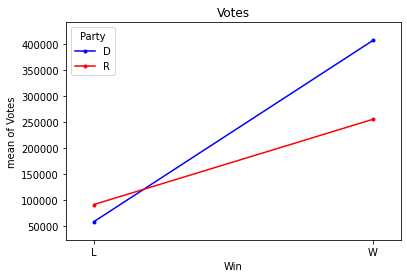

Followers
F_onewayResult(statistic=11.642770066064156, pvalue=1.2123451824032353e-05)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


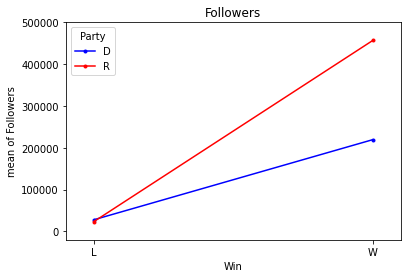

Bio_Length
F_onewayResult(statistic=685.3827257476102, pvalue=1.0210752196465722e-130)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


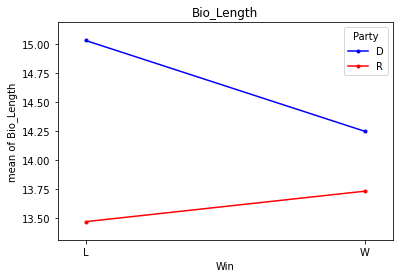

C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


bio_polarity
F_onewayResult(statistic=21.629549827215023, pvalue=1.1884926914690358e-09)


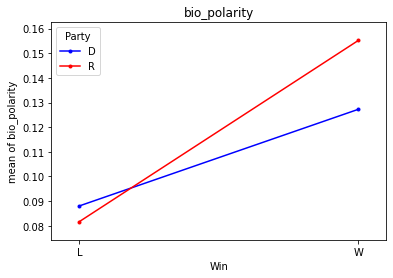

C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


bio_subjectivity
F_onewayResult(statistic=8.754426977521629, pvalue=0.00018962247152034116)


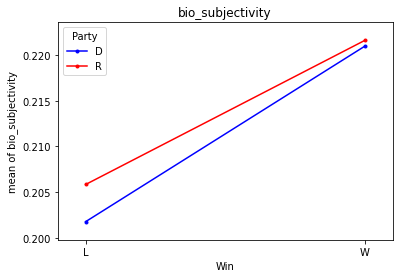

bio_profanity
F_onewayResult(statistic=31.22726736899698, pvalue=2.4401600887960123e-13)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


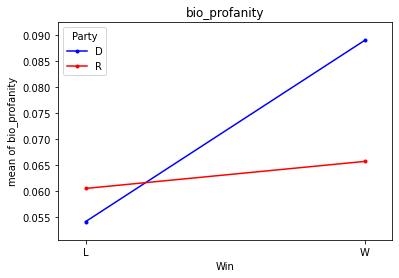

C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


num_tweets
F_onewayResult(statistic=124.46926152230309, pvalue=7.301556964970874e-43)


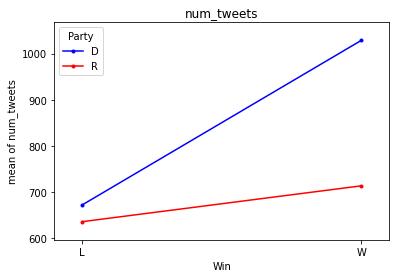

mean_tweet_length
F_onewayResult(statistic=2147.21642192021, pvalue=2.6329282368564056e-216)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


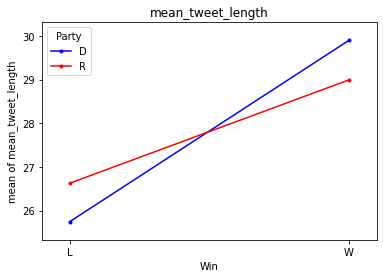

C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


mean_pct_unique
F_onewayResult(statistic=68.57730340964687, pvalue=2.2371949675490646e-26)


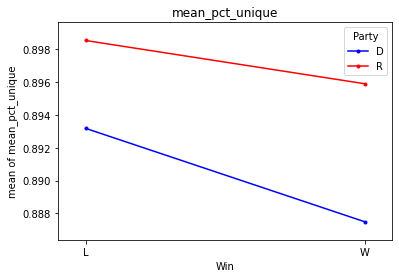

mean_tweet_polarity
F_onewayResult(statistic=20.811382607444624, pvalue=2.492406280827963e-09)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


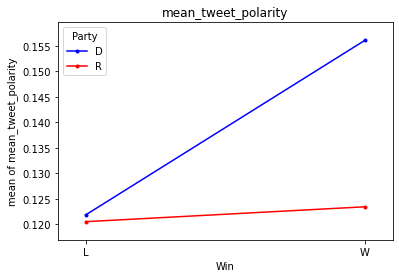

std_tweet_polarity
F_onewayResult(statistic=5.177191550407065, pvalue=0.006023315991828006)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


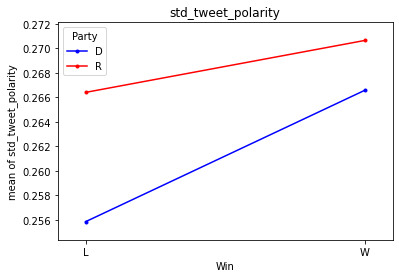

mean_tweet_subjectivity
F_onewayResult(statistic=0.5459762258590919, pvalue=0.5797017560678794)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


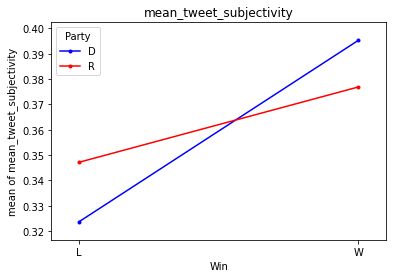

std_tweet_subjectivity
F_onewayResult(statistic=3.6498593804236164, pvalue=0.026853561489267937)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


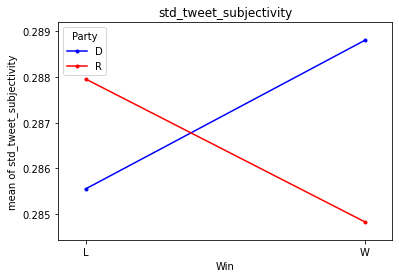

C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


mean_tweet_profanity
F_onewayResult(statistic=33.5540936730727, pvalue=3.282705751257305e-14)


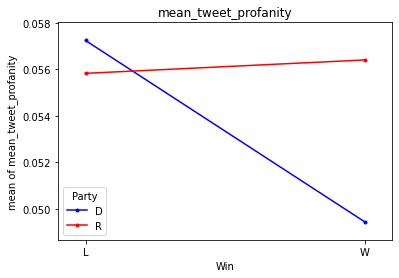

std_tweet_profanity
F_onewayResult(statistic=29.66967168987908, pvalue=9.450546247477555e-13)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


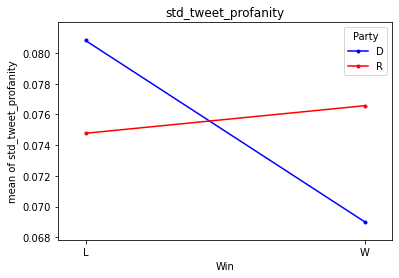

polarity_coef
F_onewayResult(statistic=45.06159563436096, pvalue=2.1389727378998942e-18)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


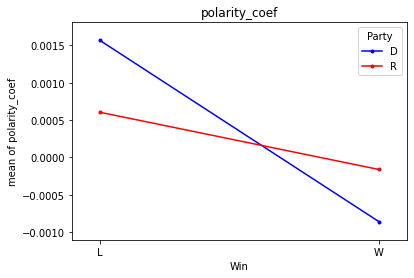

C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


subjectivity_coef
F_onewayResult(statistic=45.10860025404944, pvalue=2.058300367715826e-18)


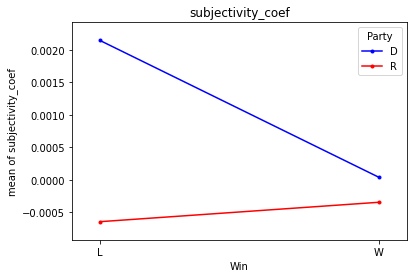

C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


profanity_coef
F_onewayResult(statistic=45.132499518935546, pvalue=2.0184626423856666e-18)


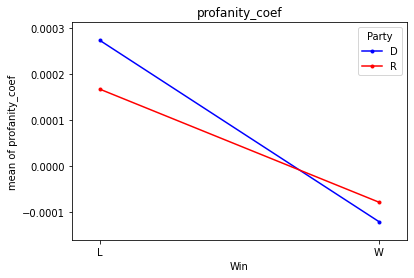

length_coef
F_onewayResult(statistic=35.78097645435671, pvalue=4.903096321098932e-15)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


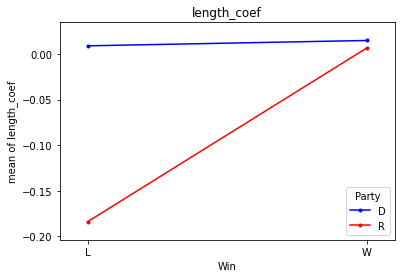

pct_unique_coef
F_onewayResult(statistic=45.13847306048792, pvalue=2.0086269605729316e-18)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


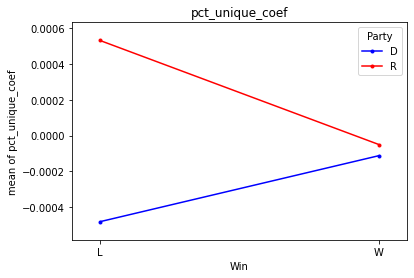

Vote_Follower_Ratio
F_onewayResult(statistic=5.972320864789538, pvalue=0.0027782211579958694)


C:\Users\katon\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


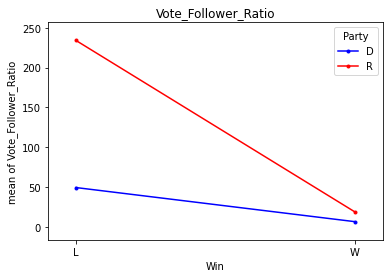

In [27]:
# Categorical interaction
for var in continuous_independent:
    print(var)
    print(stats.f_oneway(primary.Win=='W', primary.Party=='D', primary[var]))
    fig = interaction_plot(pd.Series(np.array(primary.Win), name='Win'), pd.Series(np.array(primary.Party), name='Party'), pd.Series(np.array(primary[var]), name=var), colors=['blue', 'red'])
    plt.title(var)
    plt.show()
    

<ipython-input-13-4b1248ec97b9>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


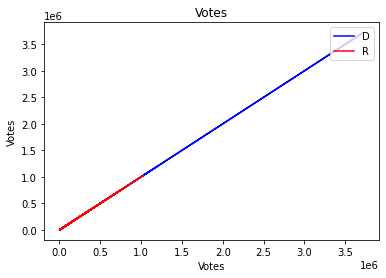

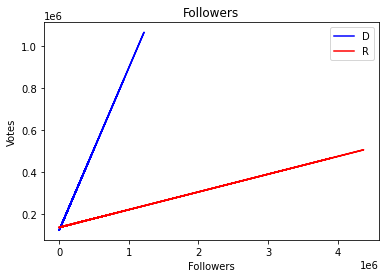

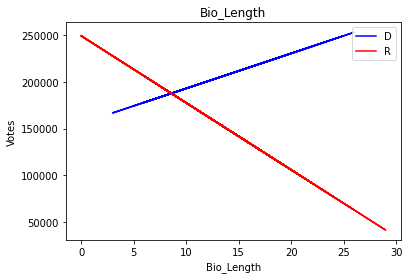

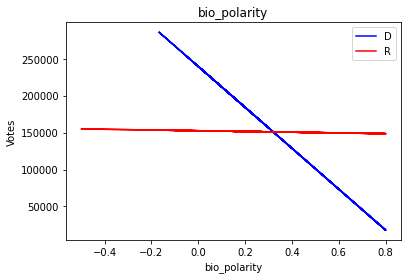

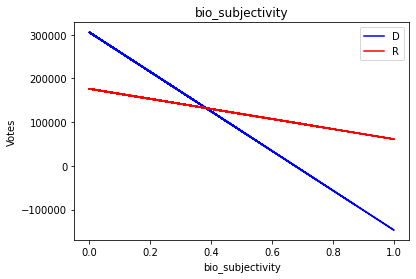

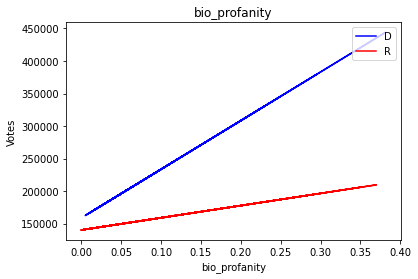

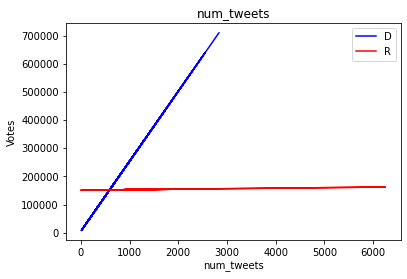

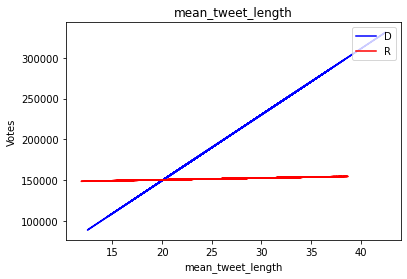

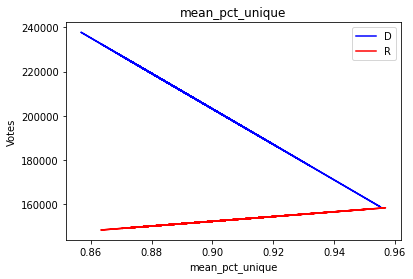

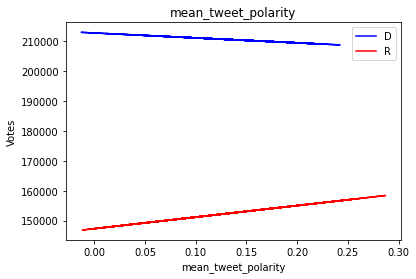

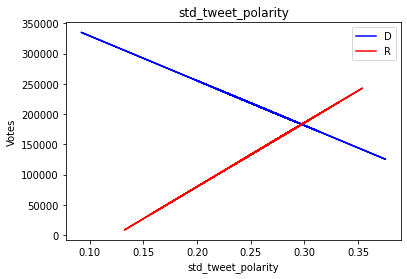

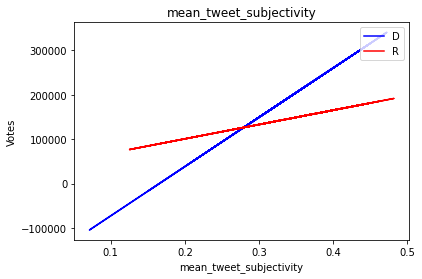

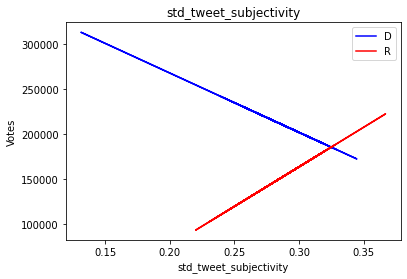

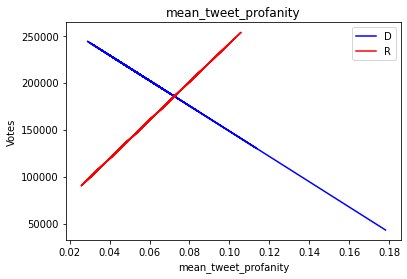

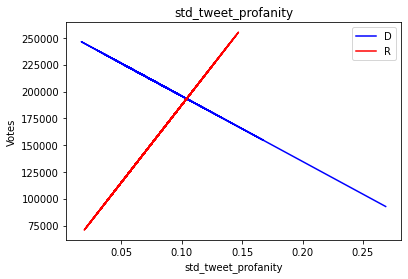

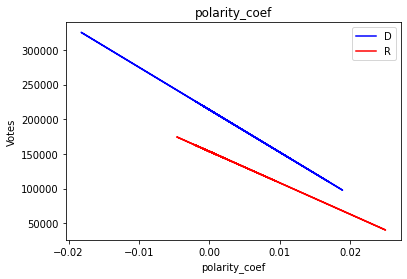

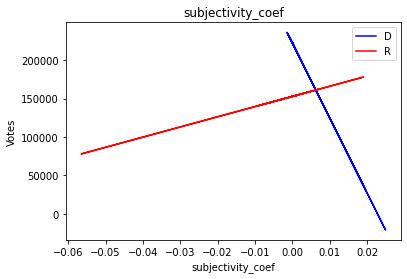

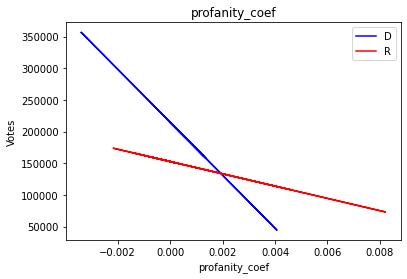

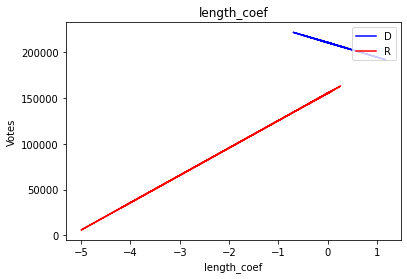

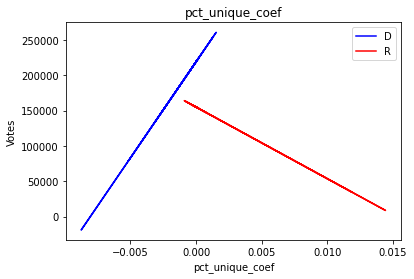

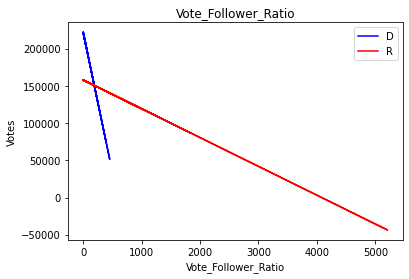

In [13]:
# Regression interaction for votes

for var in continuous_independent:
    fig = plt.figure()
    republican_X = np.array(primary_rep[var])
    republican_Y = np.array(primary_rep.Votes)
    rm, rb = np.polyfit(republican_X, republican_Y, 1)
    
    democrat_X = np.array(primary_dem[var])
    democrat_Y = np.array(primary_dem.Votes)
    dm, db = np.polyfit(democrat_X, democrat_Y, 1)
    
    plt.plot(democrat_X, dm*democrat_X + db, color='blue', label='D')
    plt.plot(republican_X, rm*republican_X + rb, color='red', label='R')
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel("Votes")
    plt.legend(loc="upper right")
    
    
    
    
    

<ipython-input-15-a53277cd938c>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


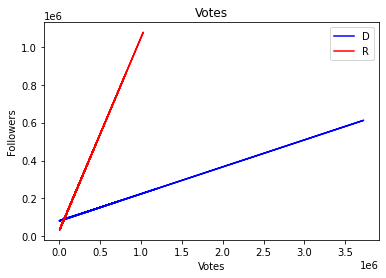

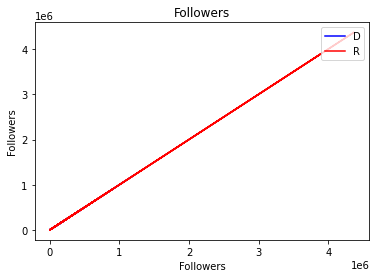

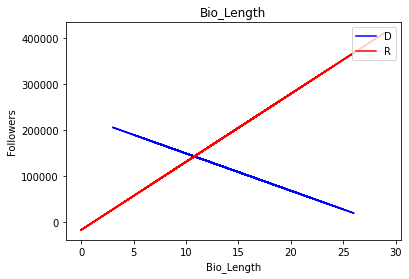

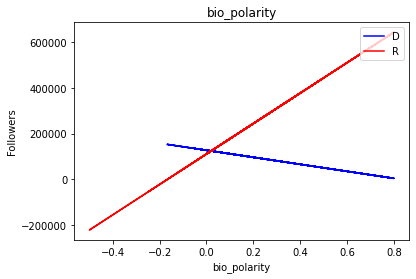

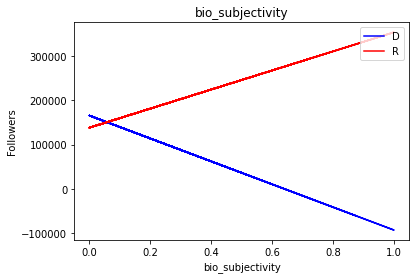

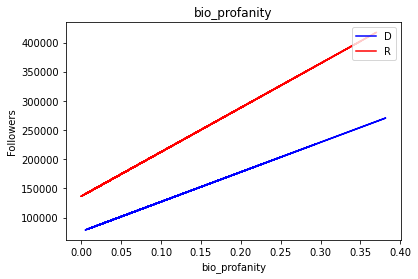

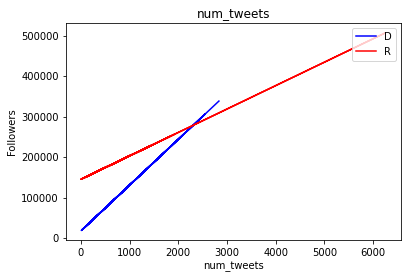

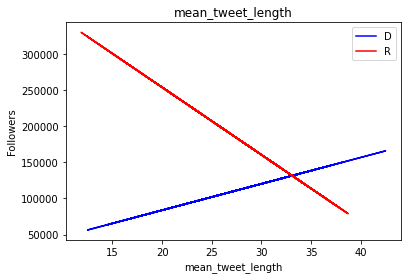

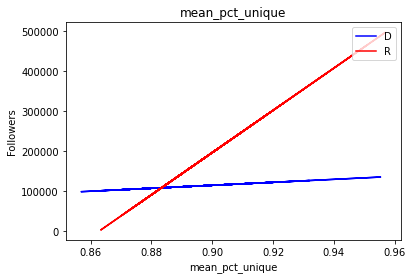

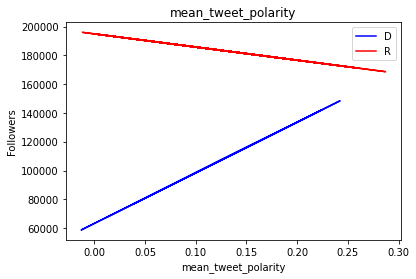

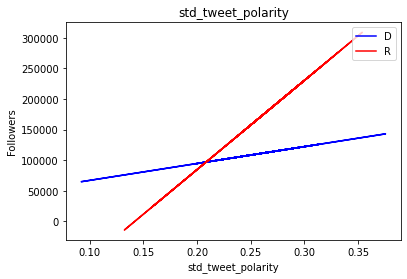

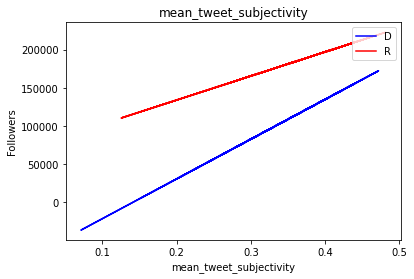

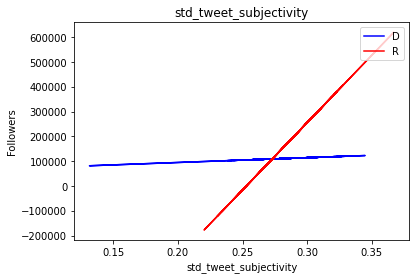

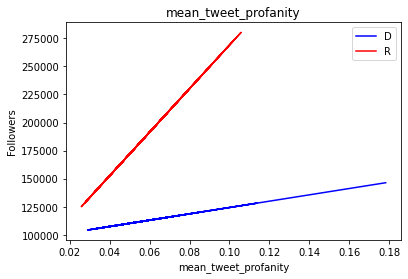

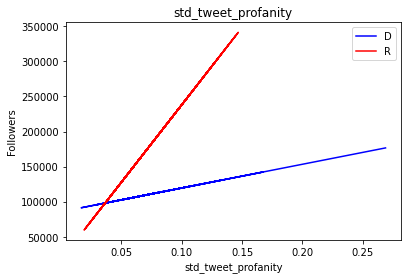

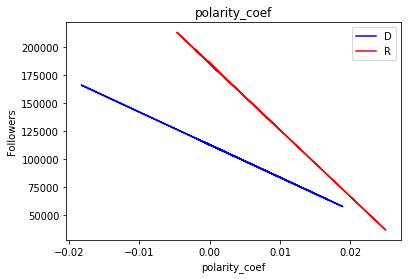

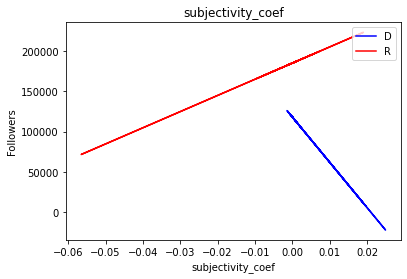

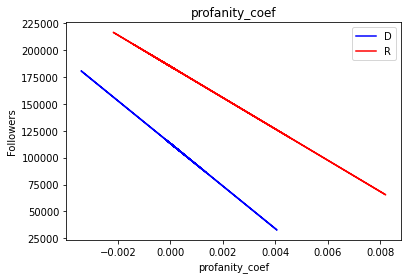

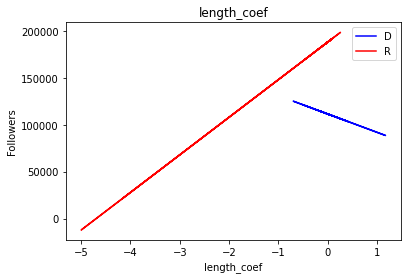

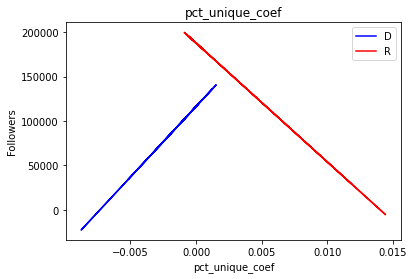

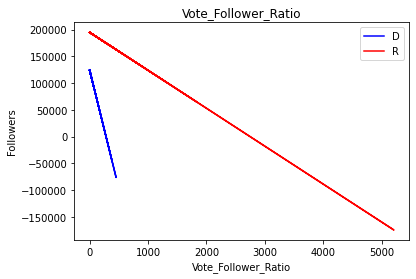

In [15]:
# Regression interaction for followers
for var in continuous_independent:
    fig = plt.figure()
    republican_X = np.array(primary_rep[var])
    republican_Y = np.array(primary_rep.Followers)
    rm, rb = np.polyfit(republican_X, republican_Y, 1)
    
    democrat_X = np.array(primary_dem[var])
    democrat_Y = np.array(primary_dem.Followers)
    dm, db = np.polyfit(democrat_X, democrat_Y, 1)
    
    plt.plot(democrat_X, dm*democrat_X + db, color='blue', label='D')
    plt.plot(republican_X, rm*republican_X + rb, color='red', label='R')
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel("Followers")
    plt.legend(loc="upper right")

### Bar charts of all effects

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Democrat', 
           x=['Polarity', 'Subjectivity', 'Profanity', 'Word Diversity'],
           y=[np.mean(primary_dem.mean_tweet_polarity), np.mean(primary_dem.mean_tweet_subjectivity), np.mean(primary_dem.mean_tweet_profanity), np.mean(primary_dem.mean_pct_unique)]),
    go.Bar(name='Republican', 
           x=['Polarity', 'Subjectivity', 'Profanity', 'Word Diversity'],
           y=[np.mean(primary_rep.mean_tweet_polarity), np.mean(primary_rep.mean_tweet_subjectivity), np.mean(primary_rep.mean_tweet_profanity), np.mean(primary_rep.mean_pct_unique)])
])
fig.update_layout(barmode='group')
fig.show()

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Democrat', 
           x=['Polarity', 'Subjectivity', 'Profanity', 'Word Diversity'],
           y=[np.mean(general_dem.mean_tweet_polarity), np.mean(general_dem.mean_tweet_subjectivity), np.mean(general_dem.mean_tweet_profanity), np.mean(general_dem.mean_pct_unique)]),
    go.Bar(name='Republican', 
           x=['Polarity', 'Subjectivity', 'Profanity', 'Word Diversity'],
           y=[np.mean(general_rep.mean_tweet_polarity), np.mean(general_rep.mean_tweet_subjectivity), np.mean(general_rep.mean_tweet_profanity), np.mean(general_rep.mean_pct_unique)])
])
fig.update_layout(barmode='group')
fig.show()

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Win', 
           x=['Polarity', 'Subjectivity', 'Profanity', 'Word Diversity'],
           y=[np.mean(general_win.mean_tweet_polarity), np.mean(general_win.mean_tweet_subjectivity), np.mean(general_win.mean_tweet_profanity), np.mean(general_win.mean_pct_unique)]),
    go.Bar(name='Loss', 
           x=['Polarity', 'Subjectivity', 'Profanity', 'Word Diversity'],
           y=[np.mean(general_loss.mean_tweet_polarity), np.mean(general_loss.mean_tweet_subjectivity), np.mean(general_loss.mean_tweet_profanity), np.mean(general_loss.mean_pct_unique)])
])
fig.update_layout(barmode='group')
fig.show()

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Win', 
           x=['Polarity', 'Subjectivity', 'Profanity', 'Word Diversity'],
           y=[np.mean(primary_win.mean_tweet_polarity), np.mean(primary_win.mean_tweet_subjectivity), np.mean(primary_win.mean_tweet_profanity), np.mean(primary_win.mean_pct_unique)]),
    go.Bar(name='Loss', 
           x=['Polarity', 'Subjectivity', 'Profanity', 'Word Diversity'],
           y=[np.mean(primary_loss.mean_tweet_polarity), np.mean(primary_loss.mean_tweet_subjectivity), np.mean(primary_loss.mean_tweet_profanity), np.mean(primary_loss.mean_pct_unique)])
])
fig.update_layout(barmode='group')
fig.show()

### Subjectivity and Polarity Plots by Party

In [ ]:
# Scatter all subjectivity and polarity for primary
fig = px.scatter(primary, x="mean_tweet_polarity", y="mean_tweet_subjectivity", 
                 color="Party", color_discrete_sequence=['blue', 'red'], size='size')
fig.show()

In [ ]:
fig = px.scatter(general, x="mean_tweet_polarity", y="mean_tweet_subjectivity", 
                 color="Party", color_discrete_sequence=['red', 'blue'], size='size')
fig.show()

In [ ]:
fig = px.scatter(primary, x="std_tweet_polarity", y="std_tweet_subjectivity", 
                 color="Party", color_discrete_sequence=['blue', 'red'], size='size')
fig.show()

In [ ]:
fig = px.scatter(general, x="std_tweet_polarity", y="std_tweet_subjectivity", 
                 color="Party", color_discrete_sequence=['red', 'blue'], size='size')
fig.show()

### Subjectivity/Polarity Plots by Victory

In [ ]:
# Scatter all subjectivity and polarity for primary
fig = px.scatter(primary, x="mean_tweet_polarity", y="mean_tweet_subjectivity", 
                 color="Win", size='size')
fig.show()

In [ ]:
# Scatter all subjectivity and polarity for primary
fig = px.scatter(general, x="mean_tweet_polarity", y="mean_tweet_subjectivity", 
                 color="Win", size='size')
fig.show()

### Word Count/Pct Unique

In [ ]:
fig = px.scatter(primary, x='mean_tweet_length', y='mean_pct_unique',
                color='Party', color_discrete_sequence=['red', 'blue'], size='size')
fig.show()

In [ ]:
fig = px.scatter(general, x='mean_tweet_length', y='mean_pct_unique',
                color='Party', color_discrete_sequence=['red', 'blue'], size='size')
fig.show()

### Profanity

In [ ]:
fig = px.scatter(general, x='mean_tweet_polarity', y='mean_tweet_profanity',
                color='Party', color_discrete_sequence=['red', 'blue'], size='size')
fig.show()

In [ ]:
fig = px.scatter(general, x='mean_tweet_polarity', y='mean_tweet_profanity',
                color='Win', color_discrete_sequence=['red', 'blue'], size='size')
fig.show()

### Followers/Votes

In [ ]:
fig = px.scatter(general, x='Followers', y='Votes',
                color='Party', color_discrete_sequence=['red', 'blue'], size='size')
fig.show()

In [ ]:
fig = px.scatter(primary, x='Followers', y='Votes',
                color='Party', color_discrete_sequence=['blue', 'red'], size='size')
fig.show()

### Effect/Votes

In [ ]:
fig = px.scatter(primary, x='Votes', y='mean_tweet_subjectivity',
                color='Party', color_discrete_sequence=['blue', 'red'], size='size')
fig.show()

In [ ]:
fig = px.scatter(general, x='Votes', y='mean_tweet_subjectivity',
                color='Party', color_discrete_sequence=['blue', 'red'], size='size')
fig.show()

In [ ]:
fig = px.scatter(primary, x='Votes', y='mean_tweet_polarity',
                color='Party', color_discrete_sequence=['blue', 'red'], size='size')
fig.show()

In [ ]:
fig = px.scatter(general, x='Votes', y='mean_tweet_polarity',
                color='Party', color_discrete_sequence=['blue', 'red'], size='size')
fig.show()

In [ ]:
fig = px.scatter(primary, x='Votes', y='mean_tweet_profanity',
                color='Party', color_discrete_sequence=['blue', 'red'], size='size')
fig.show()

In [ ]:
fig = px.scatter(general, x='Votes', y='mean_tweet_profanity',
                color='Party', color_discrete_sequence=['blue', 'red'], size='size')
fig.show()

In [ ]:
fig = px.scatter(primary, x='Votes', y='Followers',
                color='Party', color_discrete_sequence=['blue', 'red'], size='size')
fig.show()

# Scratchpad

In [40]:
np.mean(primary[primary.Win == 'W'].mean_tweet_subjectivity)

0.3850258280185184

In [41]:
np.mean(primary[primary.Win == 'L'].mean_tweet_subjectivity)

0.33832756785365853

In [42]:
np.mean(primary[primary.Win == 'L'].mean_tweet_profanity)


0.0563668218292683

In [43]:
np.mean(primary[primary.Win == 'W'].mean_tweet_profanity)

0.053314389722222216

In [44]:
np.mean(primary[primary.Win == 'W'].mean_tweet_length)

29.393692007962954

In [45]:
np.mean(primary[primary.Win == 'L'].mean_tweet_length)

26.292827654512198